In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential, load_model
import requests
import time
from datetime import datetime

In [16]:
import pandas as pd
import numpy as np
import requests
import time
import pandas_datareader as pdr
from datetime import datetime

def get_stock_data(ticker='AAPL', start_date='2010-01-01', end_date='2019-12-31', api_key='6LK2H5DFT0Q2TO5U'):
    """
    Get historical stock data using multiple sources with fallback options
    """
    # Convert string dates to datetime objects for consistency
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Try Alpha Vantage first
    try:
        print(f"Attempting to download {ticker} data from Alpha Vantage...")
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={api_key}'
        
        r = requests.get(url)
        data = r.json()
        
        # Check for error messages
        if 'Error Message' in data:
            raise Exception(f"Alpha Vantage API error: {data['Error Message']}")
            
        if 'Note' in data and 'API call frequency' in data['Note']:
            raise Exception("Alpha Vantage API rate limit reached. Try again later or use a different API key.")
            
        if 'Time Series (Daily)' not in data:
            raise Exception("No time series data found. Check your API key and ticker symbol.")
            
        # Convert to DataFrame
        df = pd.DataFrame(data['Time Series (Daily)']).T
        
        # Convert columns to appropriate data types
        df = df.rename(columns={
            '1. open': 'Open', 
            '2. high': 'High',
            '3. low': 'Low', 
            '4. close': 'Close',
            '5. adjusted close': 'Adj Close',
            '6. volume': 'Volume'
        })
        
        # Convert index to datetime
        df.index = pd.to_datetime(df.index)
        
        # Convert numeric columns to float
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
            
        # Sort by date (ascending)
        df = df.sort_index()
        
        # Filter by date range
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        
        if df.empty:
            raise Exception(f"No data available for {ticker} between {start_date} and {end_date}")
            
        print(f"Successfully downloaded {ticker} data with {len(df)} records from Alpha Vantage")
        return df
    
    except Exception as e:
        print(f"Error fetching data from Alpha Vantage: {e}")
        
        # Fallback 1: Try pandas_datareader with Yahoo Finance
        try:
            print(f"Attempting to download {ticker} data from Yahoo Finance...")
            df = pdr.data.get_data_yahoo(ticker, start=start_date, end=end_date)
            
            if df.empty:
                raise Exception("Empty dataframe returned")
                
            print(f"Successfully downloaded {ticker} data with {len(df)} records from Yahoo Finance")
            return df
        except Exception as e:
            print(f"Error fetching data from Yahoo Finance: {e}")
            
            # Fallback 2: Try pandas_datareader with Stooq
            try:
                print(f"Attempting to download {ticker} data from Stooq...")
                df = pdr.stooq.StooqDailyReader(ticker, start=start_date, end=end_date).read()
                
                if df.empty:
                    raise Exception("Empty dataframe returned")
                    
                print(f"Successfully downloaded {ticker} data with {len(df)} records from Stooq")
                return df
            except Exception as e:
                print(f"Error fetching data from Stooq: {e}")
                
                # Fallback 3: Generate synthetic data for testing purposes
                print("All data sources failed. Generating synthetic data for testing purposes...")
                return generate_synthetic_stock_data(ticker, start_date, end_date)

def generate_synthetic_stock_data(ticker, start_date, end_date):
    """
    Generate synthetic stock data for testing when all API sources fail
    """
    # Create date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' for business days
    
    # Set a base price (you can customize this)
    base_price = 100.0
    
    # Generate random walk with drift for price
    np.random.seed(42)  # For reproducibility
    returns = np.random.normal(0.0005, 0.015, len(date_range))  # Mean positive drift, daily volatility
    
    # Calculate price series
    close_prices = base_price * (1 + returns).cumprod()
    
    # Create dataframe
    df = pd.DataFrame(index=date_range)
    df['Close'] = close_prices
    
    # Add typical price variation within a day
    df['Open'] = df['Close'].shift(1) * (1 + np.random.normal(0, 0.003, len(df)))
    df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + np.abs(np.random.normal(0, 0.005, len(df))))
    df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - np.abs(np.random.normal(0, 0.005, len(df))))
    df['Adj Close'] = df['Close']  # For simplicity
    
    # Generate volume data (typical correlation with price moves)
    base_volume = 1000000
    df['Volume'] = base_volume + base_volume * np.abs(returns) * 10 * np.random.normal(1, 0.3, len(df))
    df['Volume'] = df['Volume'].astype(int)
    
    # Fill NaN values in first row
    df.iloc[0, df.columns.get_indexer(['Open'])] = close_prices[0] * 0.995
    
    # Ensure first day has reasonable values
    df = df.fillna(method='bfill')
    
    print(f"Generated synthetic data for {ticker} with {len(df)} records")
    print(f"Note: This is SIMULATED data for testing purposes only!")
    
    return df

# Example usage
if __name__ == "__main__":
    # Try with a new Alpha Vantage API key or use the demo key
    try:
        # Try with your key first
        API_KEY = "6LK2H5DFT0Q2TO5U"
        df = get_stock_data('AAPL', '2010-01-01', '2019-12-31', API_KEY)
    except Exception as e:
        # If that fails, try with the demo key
        print(f"Error with primary API key: {e}")
        print("Trying with demo key...")
        API_KEY = "demo"
        df = get_stock_data('AAPL', '2010-01-01', '2019-12-31', API_KEY)
    
    # Display the first few rows of data
    print("\nData Preview:")
    print(df.head())

Attempting to download AAPL data from Alpha Vantage...
Error fetching data from Alpha Vantage: No time series data found. Check your API key and ticker symbol.
Attempting to download AAPL data from Yahoo Finance...
Error fetching data from Yahoo Finance: 'NoneType' object has no attribute 'group'
Attempting to download AAPL data from Stooq...
Successfully downloaded AAPL data with 2516 records from Stooq

Data Preview:
               Open     High      Low    Close     Volume
Date                                                     
2019-12-31  70.1923  71.0979  70.0927  71.0911  104284023
2019-12-30  70.0789  70.8625  69.0521  70.5778  148942390
2019-12-27  70.4820  71.1699  69.7538  70.1597  151145251
2019-12-26  68.9575  70.2052  68.9287  70.1874   96379910
2019-12-24  68.9257  68.9743  68.4943  68.8225   50059857


In [17]:
print("Original data shape:", df.shape)
print(df.head())

Original data shape: (2516, 5)
               Open     High      Low    Close     Volume
Date                                                     
2019-12-31  70.1923  71.0979  70.0927  71.0911  104284023
2019-12-30  70.0789  70.8625  69.0521  70.5778  148942390
2019-12-27  70.4820  71.1699  69.7538  70.1597  151145251
2019-12-26  68.9575  70.2052  68.9287  70.1874   96379910
2019-12-24  68.9257  68.9743  68.4943  68.8225   50059857


In [19]:
df = df.drop(['Adj Close'], axis=1, errors='ignore')

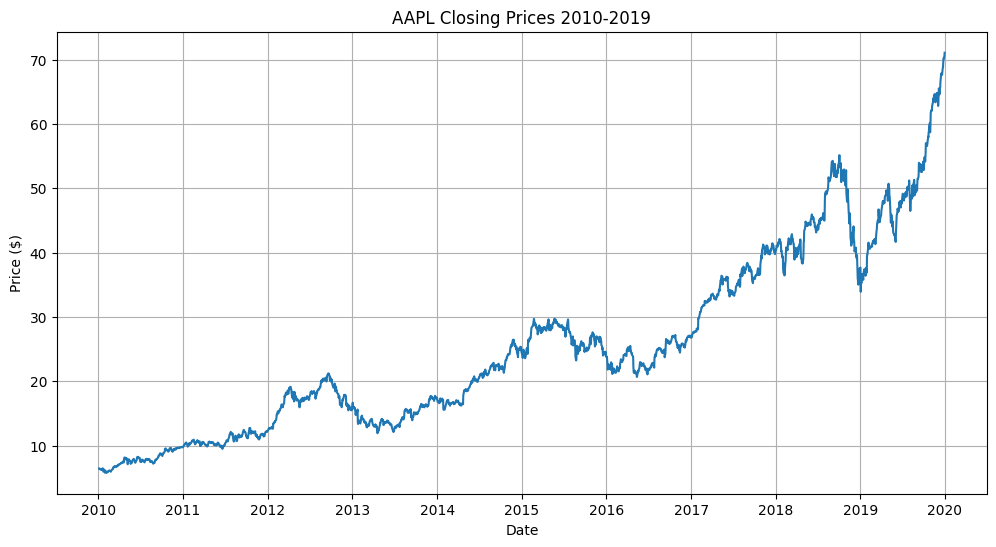

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.Close)
plt.title('AAPL Closing Prices 2010-2019')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)

In [21]:
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

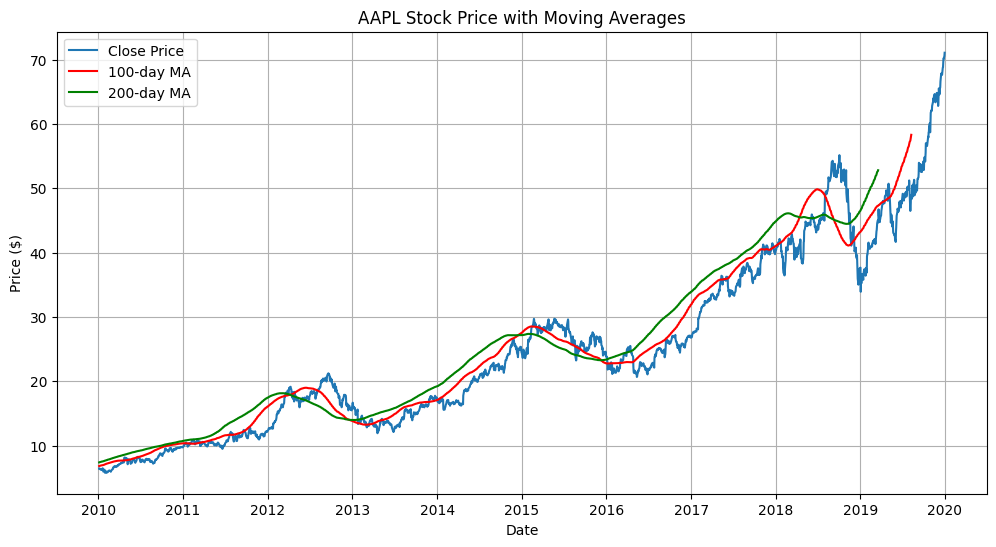

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.Close, label='Close Price')
plt.plot(df.index, ma100, 'r', label='100-day MA')
plt.plot(df.index, ma200, 'g', label='200-day MA')
plt.title('AAPL Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

In [23]:
train_size = int(len(df) * 0.7)
data_training = pd.DataFrame(df['Close'][:train_size])
data_testing = pd.DataFrame(df['Close'][train_size:])

print(f"Training data shape: {data_training.shape}")
print(f"Testing data shape: {data_testing.shape}")

Training data shape: (1761, 1)
Testing data shape: (755, 1)


In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_scaled = scaler.fit_transform(data_training)

In [26]:
# Prepare data for LSTM model (sequence of 100 days to predict the next day)
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

In [27]:
# Create sequences for training
seq_length = 100
x_train, y_train = create_sequences(data_training_scaled, seq_length)

In [28]:
# Reshape for LSTM [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1661, 100, 1)
y_train shape: (1661,)


In [29]:
# Build and train LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

c:\Users\kriti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 0.0425
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0043
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.0040
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0039
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0043
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0044
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0027
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0031
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0027
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0031
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0030
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0029
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0027
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0023
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - 

In [30]:
model.save('keras_model.h5')

In [31]:
# Prepare the test data
# Get the last 100 days from training data to predict the first day of test data
inputs = pd.concat([data_training.tail(seq_length), data_testing])
inputs = scaler.transform(inputs)

In [35]:
# Create sequences for testing
x_test, y_test = [], []
for i in range(seq_length, len(inputs)):
    x_test.append(inputs[i-seq_length:i, 0])
    y_test.append(inputs[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

In [36]:
# Reshape for LSTM input
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (755, 100, 1)
y_test shape: (755,)


In [37]:
# Make predictions
y_pred = model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [38]:
# Inverse transform to get actual price values
predicted_prices = scaler.inverse_transform(y_pred)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [39]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 23.42
Root Mean Squared Error: 4.84
Mean Absolute Error: 4.27


In [41]:
print("test_dates shape:", test_dates.shape)
print("actual_prices shape:", actual_prices.shape)
print("predicted_prices shape:", predicted_prices.shape)

test_dates shape: (655,)
actual_prices shape: (755, 1)
predicted_prices shape: (755, 1)


test_dates length: 655
actual_prices length: 655
predicted_prices length: 655


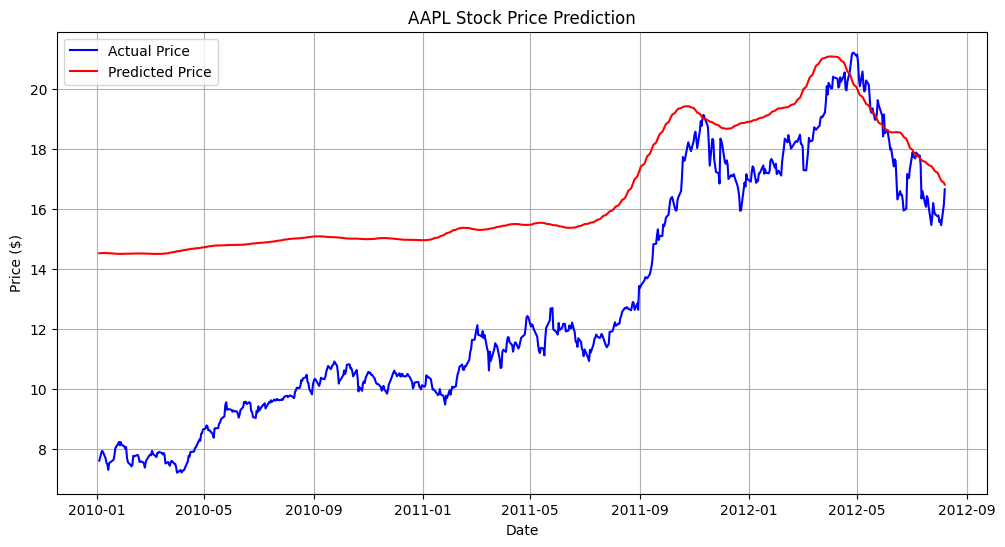

In [42]:
# Ensure shapes match
test_dates = df.index[train_size + seq_length:]
actual_prices = actual_prices[:len(test_dates)]  # Trim to match test_dates
predicted_prices = predicted_prices[:len(test_dates)]  # Trim to match test_dates

# If actual_prices and predicted_prices are 2D (e.g., (755, 1)), flatten them
if actual_prices.ndim > 1:
    actual_prices = actual_prices.flatten()
if predicted_prices.ndim > 1:
    predicted_prices = predicted_prices.flatten()

# Verify shapes
print("test_dates length:", len(test_dates))
print("actual_prices length:", len(actual_prices))
print("predicted_prices length:", len(predicted_prices))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, 'b', label='Actual Price')
plt.plot(test_dates, predicted_prices, 'r', label='Predicted Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Create a DataFrame with results for better analysis
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_prices.flatten(),
    'Predicted': predicted_prices.flatten(),
    'Difference': actual_prices.flatten() - predicted_prices.flatten()
})
print(results_df.head())

        Date   Actual  Predicted  Difference
0 2012-08-07  16.6696  16.824169   -0.154569
1 2012-08-06  16.1564  16.888571   -0.732171
2 2012-08-03  15.4714  16.956144   -1.484744
3 2012-08-02  15.6381  17.025015   -1.386915
4 2012-08-01  15.5749  17.092892   -1.517992


In [44]:
# For future predictions (predict next day)
def predict_next_day(model, last_sequence, scaler):
    # Reshape the last sequence for prediction
    last_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predict the next day's price
    next_day_scaled = model.predict(last_sequence)
    # Inverse transform to get the actual price
    next_day_price = scaler.inverse_transform(next_day_scaled)
    return next_day_price[0][0]

In [45]:
# Get the last sequence from our test data
last_sequence = x_test[-1]
next_day_price = predict_next_day(model, last_sequence, scaler)
next_day_date = df.index[-1] + pd.Timedelta(days=1)
print(f"Predicted price for {next_day_date.strftime('%Y-%m-%d')}: ${next_day_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted price for 2010-01-05: $14.37


In [46]:
# Function to save prediction results
def save_results(filename, results_df):
    try:
        results_df.to_csv(filename)
        print(f"Results saved to {filename}")
    except Exception as e:
        print(f"Error saving results: {e}")

In [47]:
# Save the results
save_results('stock_prediction_results.csv', results_df)

Results saved to stock_prediction_results.csv
